In [1]:
import os, mne, pyxdf
import numpy as np
import pandas as pd

%matplotlib widget
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

BIDS_ROOT = os.path.join("../")

# create events

In [2]:
file_path = os.path.join(BIDS_ROOT, 'sub-001', 'sub-001_ses-S001_task-Default_run-001_eeg.xdf')
streams, fileheader = pyxdf.load_xdf(file_path)

# Find the first timestamp of the EEG data to align event timestamps
first_timestamp = None
for stream in streams:
    if stream['info']['type'][0] == 'EEG':
        first_timestamp = stream['time_stamps'][0]
        break
if first_timestamp is None:
    raise ValueError('No EEG stream found')
print(f'First EEG timestamp: {first_timestamp}')

# Extract the EEG and marker streams
eeg_stream = next((stream for stream in streams if stream['info']['type'][0] == 'EEG'), None)
if eeg_stream is None:
    raise ValueError('No EEG stream found')

marker_stream = next((stream for stream in streams if stream['info']['type'][0] == 'Markers'), None)
if marker_stream is None:
    marker_info = []
else:
    markers = marker_stream['time_series']
    timestamps = marker_stream['time_stamps']
    adjusted_timestamps = timestamps - first_timestamp # Subtract the first timestamp from all marker timestamps
    marker_info = list(zip(markers, adjusted_timestamps))

# Create the MNE RawArray object
sfreq = float(eeg_stream['info']['nominal_srate'][0])
ch_names = [ch['label'][0] for ch in eeg_stream['info']['desc'][0]['channels'][0]['channel']]
eeg_data = np.array(eeg_stream['time_series']).T[:4]
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types='eeg')
raw = mne.io.RawArray(eeg_data, info)

event_data = []
# durations for each video in seconds (LEGO + 8 ads)
video_durations = {
    '1': 275, '2': 30, '3': 30, '4': 75, '5': 15,
    '6': 190, '7': 30, '8': 30, '9': 30, '10': 15
}

# Process each marker
for marker, timestamp in marker_info:
    if marker and marker[0].isdigit():
        onset_sample = int(timestamp * sfreq)
        duration_samples = int(video_durations[marker[0]] * sfreq)
        event_data.append([onset_sample, duration_samples, int(marker[0])])

event_df = pd.DataFrame(event_data, columns=['onset', 'duration', 'event_id'])
csv_file_path = os.path.join(BIDS_ROOT, 'sub-001', 'sub-001_task-events.csv')
event_df.to_csv(csv_file_path, index=False)

print(f'Event file saved to {csv_file_path}')


First EEG timestamp: 513518.4163567717
Creating RawArray with float64 data, n_channels=4, n_times=201539
    Range : 0 ... 201538 =      0.000 ...   806.152 secs
Ready.
Event file saved to ../sub-001/sub-001_task-events.csv


Using matplotlib as 2D backend.


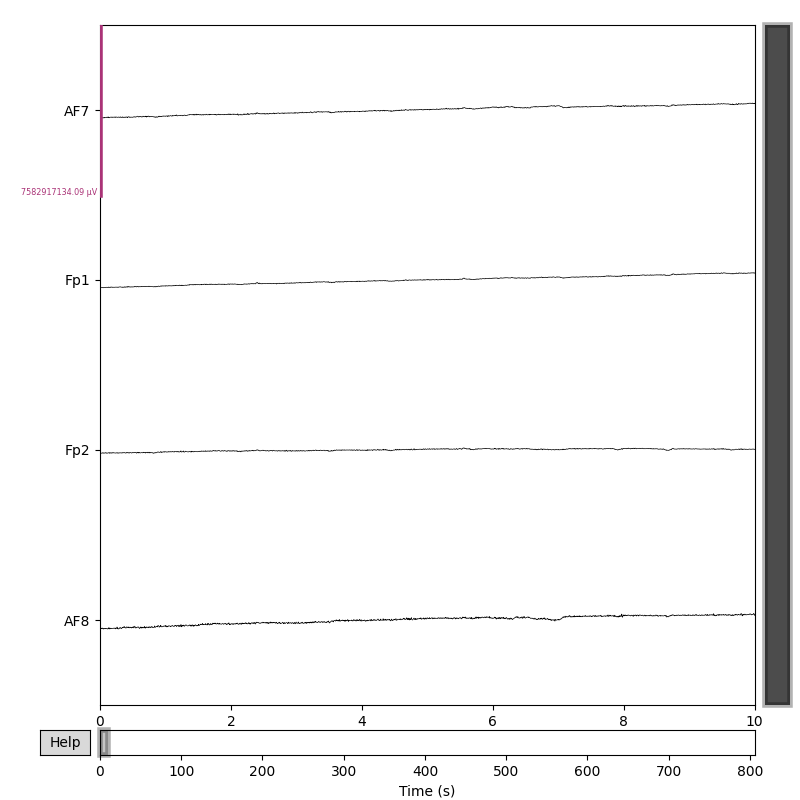

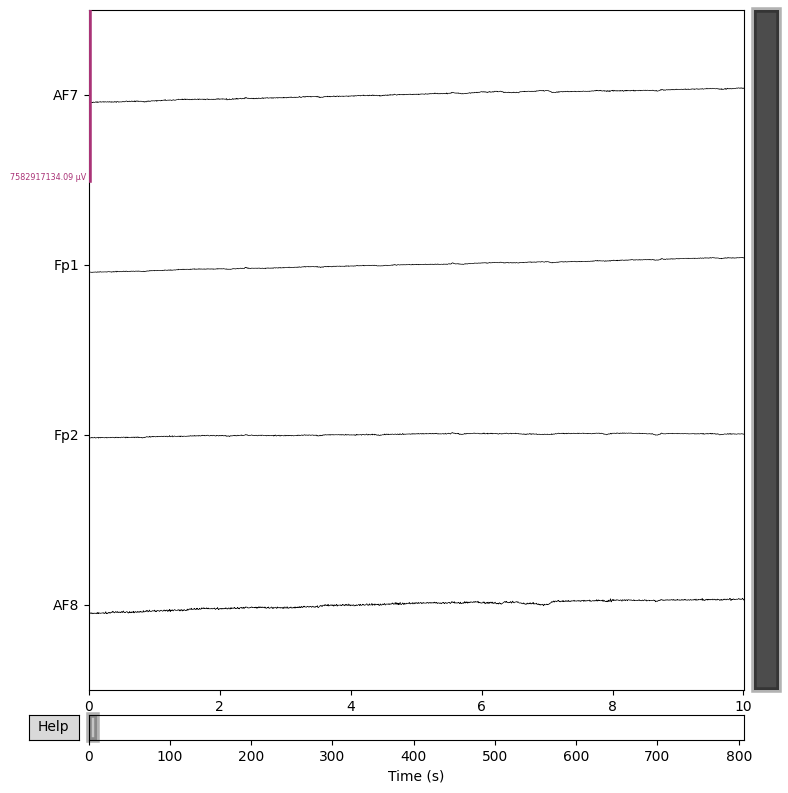

In [3]:
raw.plot(scalings='auto', n_channels=4, start=0, title='EEG data')

In [6]:
event_data

[[2645, 68750, 1],
 [73086, 7500, 2],
 [82379, 7500, 3],
 [91674, 18750, 4],
 [111875, 3750, 5],
 [117325, 47500, 6],
 [166528, 7500, 7],
 [175581, 7500, 8],
 [184747, 7500, 9],
 [193898, 3750, 10]]